In [ ]:
# ============================================
# 🔍 FRAMEWORK DE VALIDACIÓN PARA SERIES CORTAS
# Proyecto: NEXO WEFE - Producción Agrícola en Galápagos
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --------------------------------------------
# 1️⃣ SUBIR ARCHIVO .CSV
# --------------------------------------------
from google.colab import files
uploaded = files.upload()

# Detectar el archivo subido automáticamente
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)
print(f"\n✅ Archivo cargado correctamente: {filename}")
print("Dimensiones:", data.shape)
display(data.head())


Saving data.csv to data (1).csv

✅ Archivo cargado correctamente: data (1).csv
Dimensiones: (20, 4)


,anio,precipitacion,produccion_agricola,energia_per_capita
0,2005,15.50,NaN,1.21
1,2006,14.32,NaN,1.17
2,2007,17.30,NaN,1.13
3,2008,64.00,NaN,1.26
4,2009,18.26,NaN,1.30


In [ ]:
# --------------------------------------------
# 2️⃣ EVALUACIÓN DE CALIDAD DE DATOS
# --------------------------------------------
def evaluate_data_quality(df):
    quality = {}
    quality['faltantes_%'] = df.isnull().mean().mean() * 100
    quality['duplicados'] = df.duplicated().sum()
    quality['outliers_estimados'] = np.mean([
        ((df[col] > df[col].quantile(0.95)) | (df[col] < df[col].quantile(0.05))).mean()
        for col in df.select_dtypes(include=np.number).columns
    ]) * 100
    return quality

quality_report = evaluate_data_quality(data)
print("\n📊 Reporte de calidad de datos:")
for k, v in quality_report.items():
    print(f"- {k}: {v:.2f}")


📊 Reporte de calidad de datos:
- faltantes_%: 22.50
- duplicados: 0.00
- outliers_estimados: 10.00


In [ ]:
# --------------------------------------------
# 3️⃣ IMPUTACIÓN AVANZADA (Interpolación Temporal)
# --------------------------------------------
data_interpolated = data.copy()
for col in data.select_dtypes(include=np.number).columns:
    data_interpolated[col] = data[col].interpolate(method='linear', limit_direction='both')

print("\n🔧 Imputación temporal completada.")


🔧 Imputación temporal completada.


In [ ]:
# --------------------------------------------
# 4️⃣ VALIDACIÓN CRUZADA TEMPORAL BLOQUEADA
# --------------------------------------------
def temporal_cross_validation(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
    return scores

target_col = 'produccion_agricola'
features = data_interpolated.drop(columns=[target_col])
target = data_interpolated[target_col]

# Escalado
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Modelo base
xgb = XGBRegressor(random_state=42)
cv_scores = temporal_cross_validation(xgb, X_scaled, target)

print("\n📈 Resultados Validación Cruzada Temporal:")
print("RMSE por bloque:", np.round(cv_scores, 2))
print("RMSE promedio:", np.mean(cv_scores))



📈 Resultados Validación Cruzada Temporal:
RMSE por bloque: [0.00000e+00 2.30940e+03 6.92838e+03 1.20000e-01 1.20000e-01]
RMSE promedio: 1847.6069458362138


In [ ]:
# --------------------------------------------
# 5️⃣ PRUEBAS CON DATOS SINTÉTICOS (ROBUSTEZ)
# --------------------------------------------
def synthetic_robustness_test(model, X, y, perturbation_factor=0.05):
    """Evalúa la estabilidad del modelo ante pequeñas perturbaciones"""
    y_pred_baseline = model.fit(X, y).predict(X)
    baseline_r2 = r2_score(y, y_pred_baseline)

    # Generar versiones perturbadas
    synthetic_scores = []
    for i in range(10):
        X_synthetic = X + np.random.normal(0, perturbation_factor, X.shape)
        y_pred_synth = model.predict(X_synthetic)
        synthetic_r2 = r2_score(y, y_pred_synth)
        synthetic_scores.append(synthetic_r2)
    return baseline_r2, np.mean(synthetic_scores), np.std(synthetic_scores)

baseline_r2, mean_r2_synth, std_r2_synth = synthetic_robustness_test(xgb, X_scaled, target)
print("\n🧪 Robustez del modelo:")
print(f"R² base: {baseline_r2:.3f}")
print(f"R² sintético promedio: {mean_r2_synth:.3f}")
print(f"Desviación R² sintético: {std_r2_synth:.3f}")


🧪 Robustez del modelo:
R² base: 1.000
R² sintético promedio: 0.965
Desviación R² sintético: 0.025


In [ ]:
# --------------------------------------------
# 6️⃣ MÉTRICAS DE NEGOCIO ESPECÍFICAS
# --------------------------------------------
def business_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    eficiencia = 100 - mape
    return {'MAE': mae, 'MAPE (%)': mape, 'Eficiencia Productiva (%)': eficiencia}

xgb.fit(X_scaled, target)
pred = xgb.predict(X_scaled)
biz_metrics = business_metrics(target, pred)

print("\n💼 Métricas de negocio:")
for k, v in biz_metrics.items():
    print(f"- {k}: {v:.2f}")


💼 Métricas de negocio:
- MAE: 0.06
- MAPE (%): 0.00
- Eficiencia Productiva (%): 100.00


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


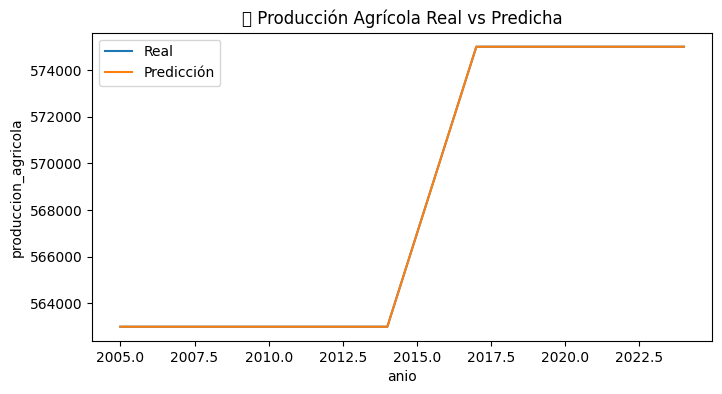


✅ Framework ejecutado con éxito.


In [ ]:
# --------------------------------------------
# 7️⃣ VISUALIZACIONES
# --------------------------------------------
plt.figure(figsize=(8,4))
sns.lineplot(x=data['anio'], y=target, label='Real')
sns.lineplot(x=data['anio'], y=pred, label='Predicción')
plt.title("📉 Producción Agrícola Real vs Predicha")
plt.legend()
plt.show()

print("\n✅ Framework ejecutado con éxito.")